# Development of Algorithms for ERDDAP Dataset from ONC CTD Data

Figuring out how to transform a day's ONC CTD data from a SoG node into
a netCDF file that is part of an ERDDAP dataset:

* filter the ONC data to include only `qaqcFlag == 1` samples
* remove the `qaqcFlag` arrays as variable attributes
* aggregate the data into 15 minute time bins;
mean, variance, and count for each variable in each time bin
* store dataset as netCDF file
* generate ERDDAP `/opt/tomcat/content/erddap/datasets.xml` fragment

In [3]:
from collections import OrderedDict
import os

import arrow
from lxml import etree
import matplotlib.pyplot as plt
import xarray as xr

from salishsea_tools import data_tools
from salishsea_tools.places import PLACES

In [4]:
%matplotlib inline

## Get Data from ONC `scalardata` Web Service

Access to the ONC web services requires a user token which you can generate on the 
`Web Services API` tab of your [ONC account profile page](http://dmas.uvic.ca/Profile).
I have stored mine in an environment variable so as not to publish it to the world
in this notebook.

In [6]:
TOKEN = os.environ['ONC_USER_TOKEN']

Request a day's worth of CTD salinity and temperature data
and parse them into an `xarray.Dataset`:

In [7]:
onc_data = data_tools.get_onc_data(
    'scalardata', 'getByStation', TOKEN,
    station='SCVIP', deviceCategory='CTD',
    sensors='salinity,temperature',
    dateFrom=data_tools.onc_datetime('2016-07-24 00:00', 'utc'),
)

ctd_data = data_tools.onc_json_to_dataset(onc_data)

In [8]:
ctd_data

<xarray.Dataset>
Dimensions:      (sampleTime: 86399)
Coordinates:
  * sampleTime   (sampleTime) datetime64[ns] 2016-07-24T00:00:00.108000 ...
Data variables:
    salinity     (sampleTime) float64 31.25 31.25 31.25 31.25 31.25 31.25 ...
    temperature  (sampleTime) float64 9.468 9.467 9.467 9.468 9.468 9.467 ...
Attributes:
    station: SCVIP
    dateFrom: 2016-07-24T00:00:00.000Z
    rowLimit: None
    outputFormat: None
    totalActualSamples: 172798
    sensors: salinity,temperature
    deviceCategory: CTD
    dateTo: None
    nextDateFrom: 2016-07-25T00:00:00.550Z

## Filter Data Based on `qaqcFlag` Values

Filter the salinity data to exclude samples for which `qaqcFlag != 1`:

In [9]:
ctd_data.salinity

<xarray.DataArray 'salinity' (sampleTime: 86399)>
array([ 31.24695124,  31.24715219,  31.24725266, ...,  31.24072201,
        31.24082248,  31.24062154])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2016-07-24T00:00:00.108000 ...
Attributes:
    actualSamples: 86399
    qaqcFlag: [1 1 1 ..., 1 1 1]
    sensorName: Reference Salinity
    unitOfMeasure: g/kg

In [10]:
salinity_qaqc_mask = ctd_data.salinity.attrs['qaqcFlag'] == 1
salinity = xr.DataArray(
    name='salinity',
    data=ctd_data.salinity[salinity_qaqc_mask].values,
    coords={'time': ctd_data.salinity.sampleTime[salinity_qaqc_mask].values},
)

In [11]:
salinity

<xarray.DataArray 'salinity' (time: 86299)>
array([ 31.24695124,  31.24715219,  31.24725266, ...,  31.24072201,
        31.24082248,  31.24062154])
Coordinates:
  * time     (time) datetime64[ns] 2016-07-24T00:00:00.108000 ...

Filter the temperature data to exclude samples for which `qaqcFlag != 1`:

In [12]:
ctd_data.temperature

<xarray.DataArray 'temperature' (sampleTime: 86399)>
array([ 9.4677,  9.4674,  9.4673, ...,  9.4756,  9.4755,  9.4756])
Coordinates:
  * sampleTime  (sampleTime) datetime64[ns] 2016-07-24T00:00:00.108000 ...
Attributes:
    actualSamples: 86399
    qaqcFlag: [1 1 1 ..., 1 1 1]
    sensorName: Temperature
    unitOfMeasure: C

In [13]:
temperature_qaqc_mask = ctd_data.temperature.attrs['qaqcFlag'] == 1
temperature = xr.DataArray(
    name='temperature',
    data=ctd_data.temperature[temperature_qaqc_mask].values,
    coords={'time': ctd_data.temperature.sampleTime[temperature_qaqc_mask].values},
)

In [14]:
temperature

<xarray.DataArray 'temperature' (time: 86399)>
array([ 9.4677,  9.4674,  9.4673, ...,  9.4756,  9.4755,  9.4756])
Coordinates:
  * time     (time) datetime64[ns] 2016-07-24T00:00:00.108000 ...

## Create 15 Minute Resampled Dataset

Define an aggregation function to count the samples in each
resampling interval:

In [15]:
def count(values, axis):
    return values.size

Create a dataset of resampled data and their statistics:

In [38]:
ds = xr.Dataset(
    data_vars={
        'salinity': xr.DataArray(
            name='salinity',
            data=salinity.resample('15Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'Salinity',
                'standard_name': 'sea_water_reference_salinity',
                'long_name': 'reference salinity',
                'units': 'g/kg',
                'aggregation_operation': 'mean',
                'aggregation_interval': 15*60,
                'aggregation_interval_units': 'seconds',
            },
        ),
        'salinity_std_dev': xr.DataArray(
            name='salinity_std_dev',
            data=salinity.resample('15Min', 'time', how='std'),
            attrs={
                'ioos_category': 'Salinity',
                'standard_name': 'sea_water_reference_salinity_standard_deviation',
                'long_name': 'reference salinity standard deviation',
                'units': 'g/kg',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 15*60,
                'aggregation_interval_units': 'seconds',
            },
        ),
        'salinity_sample_count': xr.DataArray(
            name='salinity_sample_count',
            data=salinity.resample('15Min', 'time', how=count),
            attrs={
                'standard_name': 'sea_water_reference_salinity_sample_count',
                'long_name': 'reference salinity sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 15*60,
                'aggregation_interval_units': 'seconds',
            },
        ),
        'temperature': xr.DataArray(
            name='temperature',
            data=temperature.resample('15Min', 'time', how='mean'),
            attrs={
                'ioos_category': 'Temperature',
                'standard_name': 'sea_water_temperature',
                'long_name': 'temperature',
                'units': 'degrees_Celcius',
                'aggregation_operation': 'mean',
                'aggregation_interval': 15*60,
                'aggregation_interval_units': 'seconds',
            },
        ),
        'temperature_std_dev': xr.DataArray(
            name='temperature_std_dev',
            data=temperature.resample('15Min', 'time', how='std'),
            attrs={
                'ioos_category': 'Temperature',
                'standard_name': 'sea_water_temperature_standard_deviation',
                'long_name': 'temperature standard deviation',
                'units': 'degrees_Celcius',
                'aggregation_operation': 'standard deviation',
                'aggregation_interval': 15*60,
                'aggregation_interval_units': 'seconds',
            },
        ),
        'temperature_sample_count': xr.DataArray(
            name='temperature_sample_count',
            data=temperature.resample('15Min', 'time', how=count),
            attrs={
                'standard_name': 'sea_water_temperature_sample_count',
                'long_name': 'temperature sample count',
                'aggregation_operation': 'count',
                'aggregation_interval': 15*60,
                'aggregation_interval_units': 'seconds',
            },
        ),
    },
    coords={
        'depth': PLACES['Central node']['depth'],
        'longitude': PLACES['Central node']['lon lat'][0],
        'latitude': PLACES['Central node']['lon lat'][1],
    },
    attrs={
        'history': """
{0} Download raw data from ONC scalardata API.
{0} Filter to exclude data with qaqcFlag != 1.
{0} Resample data to 15 minute intervals using mean, standard deviation and count as aggregation functions.
{0} Store as netCDF4 file.
        """.format(arrow.now().format('YYYY-MM-DD HH:mm:ss')),
        'ONC_station': 'Central',
        'ONC_stationCode': PLACES['Central node']['ONC stationCode'],
        'ONC_stationDescription': 
            'Pacific, Salish Sea, Strait of Georgia, Central, Strait of Georgia VENUS Instrument Platform',
        'ONC_data_product_url': 'http://dmas.uvic.ca/DataSearch?location=SCVIP&deviceCategory=CTD',
    },
)

In [39]:
ds

<xarray.Dataset>
Dimensions:                   (time: 96)
Coordinates:
  * time                      (time) datetime64[ns] 2016-07-24 ...
    longitude                 float64 -123.4
    depth                     int64 294
    latitude                  float64 49.04
Data variables:
    salinity_sample_count     (time) int64 900 898 900 897 900 900 894 899 ...
    salinity                  (time) float64 31.25 31.24 31.24 31.23 31.23 ...
    temperature_std_dev       (time) float64 0.0005151 0.0002606 0.0005805 ...
    temperature_sample_count  (time) int64 900 900 900 900 900 900 900 900 ...
    temperature               (time) float64 9.468 9.47 9.471 9.473 9.474 ...
    salinity_std_dev          (time) float64 0.0007273 0.0008953 0.001591 ...
Attributes:
    ONC_station: Central
    ONC_stationDescription: Pacific, Salish Sea, Strait of Georgia, Central, Strait of Georgia VENUS Instrument Platform
    ONC_stationCode: SCVIP
    ONC_data_product_url: http://dmas.uvic.ca/DataSearch?loc

## Examine the Dataset

<xarray.DataArray 'salinity_sample_count' (time: 96)>
array([900, 898, 900, 897, 900, 900, 894, 899, 900, 900, 900, 900, 900,
       900, 900, 900, 900, 898, 899, 900, 900, 900, 900, 900, 900, 899,
       900, 900, 900, 900, 900, 900, 899, 899, 898, 900, 898, 900, 898,
       894, 896, 900, 900, 899, 899, 892, 891, 894, 900, 900, 900, 899,
       900, 899, 899, 899, 899, 901, 898, 900, 900, 898, 900, 899, 898,
       900, 899, 900, 900, 900, 900, 900, 900, 899, 900, 900, 899, 897,
       899, 900, 900, 900, 895, 899, 900, 900, 900, 898, 899, 900, 900,
       900, 898, 894, 896, 897])
Coordinates:
  * time       (time) datetime64[ns] 2016-07-24 2016-07-24T00:15:00 ...
    longitude  float64 -123.4
    depth      int64 294
    latitude   float64 49.04
Attributes:
    aggregation_interval: 900
    aggregation_operation: count
    long_name: reference salinity sample count
    aggregation_interval_units: seconds
    standard_name: sea_water_reference_salinity_sample_count


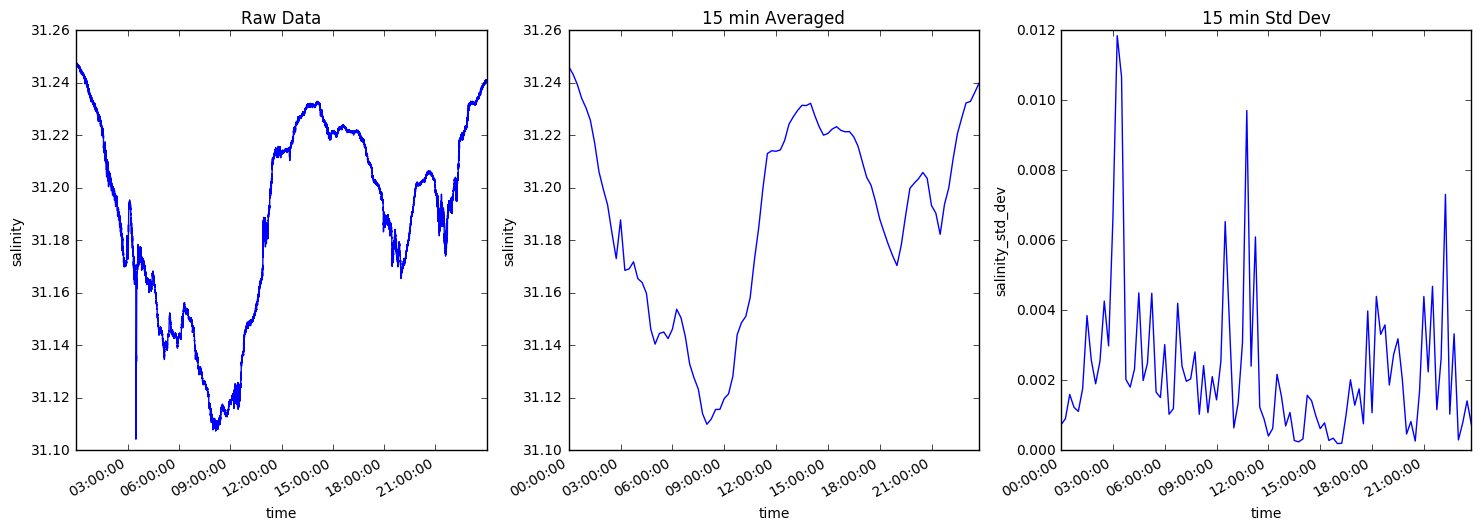

In [22]:
print(ds.salinity_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
salinity.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.salinity.plot(ax=ax2)
ax2.set_title('15 min Averaged')
ds.salinity_std_dev.plot(ax=ax3)
ax3.set_title('15 min Std Dev')

<xarray.DataArray 'temperature_sample_count' (time: 96)>
array([900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900,
       900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900,
       900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900,
       900, 900, 900, 900, 900, 900, 900, 899, 900, 900, 900, 901, 899,
       900, 900, 900, 900, 900, 901, 899, 900, 900, 900, 900, 900, 900,
       900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900,
       900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900,
       900, 900, 900, 900, 900])
Coordinates:
  * time       (time) datetime64[ns] 2016-07-24 2016-07-24T00:15:00 ...
    longitude  float64 -123.4
    depth      int64 294
    latitude   float64 49.04
Attributes:
    aggregation_interval: 900
    aggregation_operation: count
    long_name: temperature sample count
    aggregation_interval_units: seconds
    standard_name: sea_water_temperature_sample_count


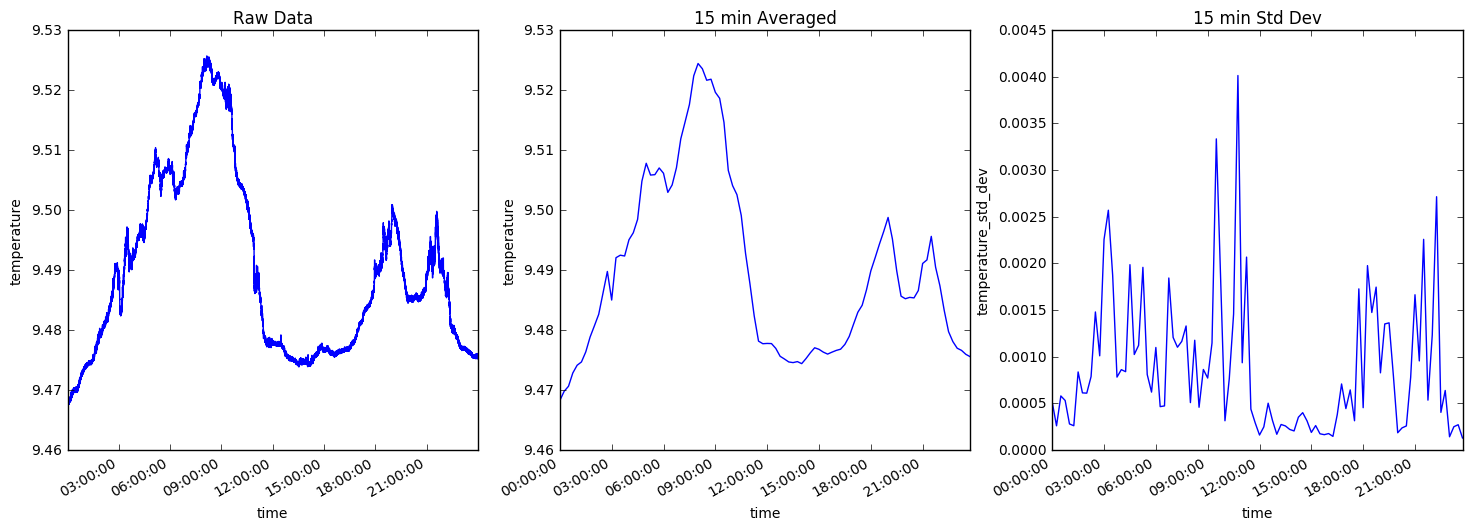

In [23]:
print(ds.temperature_sample_count)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
temperature.plot(ax=ax1)
ax1.set_title('Raw Data')
ds.temperature.plot(ax=ax2)
ax2.set_title('15 min Averaged')
ds.temperature_std_dev.plot(ax=ax3)
ax3.set_title('15 min Std Dev')

## Store the Dataset as a netCDF4 File

ERDDAP requires that all files in a dataset have the same units for their `time` variable.
On the other hand,
`xarray` defaults to using the 1st `time` value in the dataset as the time-base for the units.
So, we have to explicitly define the `time` units as an encoding when the dataset is stored
as a netCDF4 file.

In [45]:
ds.to_netcdf(
    '/results/observations/ONC/CTD/SCVIP/SCVIP_CTD_15m_20160724.nc',
    encoding={'time': {'units': 'minutes since 1970-01-01 00:00'}})

## Generate an ERDDAP Dataset XML Fragment

Use the `/opt/tomcat/webapps/erddap/WEB-INF/GenerateDatasetsXml.sh` script
generate the initial version of an XML fragment for a dataset:
```
$ cd /opt/tomcat/webapps/erddap/WEB-INF/
$ bash GenerateDatasetsXml.sh EDDTableFromNcFiles /results/observations/ONC/CTD/SCVIP/
```
The `EDDTableFromNcFiles` and `/results/observations/ONC/CTD/SCVIP/` arguments
tell the script which `EDDType` and what parent directory to use,
avoiding having to type those in answer to prompts.
Answer the remaining prompts,
for example:
```
File name regex (e.g., ".*\.nc") (default="")
? .*SCVIP_CTD_15m_\d{8}\.nc$ 
A sample full file name (default="")
? /results/observations/ONC/CTD/SCVIP/SCVIP_CTD_15m_20160724.nc
DimensionsCSV (or "" for default) (default="")
? 
ReloadEveryNMinutes (e.g., 10080) (default="")
? 10080
PreExtractRegex (default="")
? 
PostExtractRegex (default="")
? 
ExtractRegex (default="")
? 
Column name for extract (default="")
? 
Sorted column source name (default="")
? 
Sort files by sourceName (default="")
? 
infoUrl (default="")
? https://salishsea-meopar-tools.readthedocs.org/en/latest/results_server/
institution (default="")
? UBC EOAS
summary (default="")
? 
title (default="")
? ONC, Strait of Georgia, Central Node, Salinity and Temperature, 15min, v1
```

The output is written to `/results/erddap/logs/GenerateDatasetsXml.out`

The `metadata` dictionary below contains information for dataset
attribute tags whose values need to be changed,
or that need to be added for all datasets.

The keys are the dataset attribute names.

The values are dicts containing a required `text` item
and perhaps an optional `after` item.

The value associated with the `text` key is the text content
for the attribute tag.

When present,
the value associated with the `after` key is the name
of the dataset attribute after which a new attribute tag
containing the `text` value is to be inserted.

In [4]:
metadata = OrderedDict([
    ('cdm_data_type', {'text': 'TimeSeries'}),
    ('cdm_timeseries_variables', {
        'text': 'depth, longitude, latitude',
        'after': 'cdm_data_type',
    }),
    ('institution_fullname', {
        'text': 'Earth, Ocean & Atmospheric Sciences, University of British Columbia',
        'after': 'institution',
    }),
    ('license', {
        'text': '''The Salish Sea MEOPAR observation datasets are copyright 2013-2016
by the Salish Sea MEOPAR Project Contributors, The University of British Columbia, and Ocean Networks Canada.

They are licensed under the Apache License, Version 2.0. http://www.apache.org/licenses/LICENSE-2.0

Raw instrument data on which this dataset is based were provided by Ocean Networks Canada.''',
    }),
    ('project', {
        'text':'Salish Sea MEOPAR NEMO Model',
        'after': 'title',
    }),
    ('creator_name', {
        'text': 'Salish Sea MEOPAR Project Contributors',
    }),
    ('creator_email', {
        'text': 'sallen@eos.ubc.ca',
        'after': 'creator_name',
    }),
    ('creator_url', {
        'text': 'https://salishsea-meopar-docs.readthedocs.org/',
    }),
    ('acknowledgement', {
        'text': 'MEOPAR, ONC, Compute Canada',
        'after': 'creator_url',
    }),
    ('drawLandMask', {
        'text': 'over',
        'after': 'acknowledgement',
    }),
])

The `datasets` dictionary below provides the content
for the dataset `title` and `summary` attributes.

The `title` attribute content appears in the the datasets list table
(among other places).

The `summary` atribute content appears
(among other places)
when a user hovers the cursor over the `?` icon beside the `title`
content in the datasets list table.
The text that is inserted into the `summary` attribute tag
by code later in this notebook is the
`title` content followed by the `summary` content,
separated by a blank line.

The keys of the `datasets` dict are the `datasetID` strings that
are used in many places by the ERDDAP server.
They are structured as follows:

* `ubc` to indicate that the dataset was produced at UBC
* `ONC` to indicate that the dataset is a product of filter, resampling, etc.
raw instrument data provided by Ocean Networks Canada (ONC)
* a description of the dataset variables; e.g. `SCVIPCTD`
* the time interval of values in the dataset; e.g. `15m`
* the dataset version; e.g. `V1`

So:

* `ubcONCSCVIPCTD15mV1` is the version 1 dataset of 15 minute resampled CTD temperature and salinity data
from the ONC Strait of Georgia Central node VENUS instrument platform

The dataset version part of the `datasetID` is used to indicate changes in the variables
contained in the dataset.

All datasets start at `V1` and their `summary` ends with a notation about the variables
that they contain; e.g.
```
v1: reference salinity, reference salinity standard deviation, reference salinity sample counts, 
temperature, temperature standard deviation, temperature sample counts variables
```
When the a dataset version is incremented a line describing the change is added
to the end of its `summary`.

In [5]:
datasets = {
    'ubcONCSCVIPCTD15mV1' :{
        'type': 'resampled CTD',
        'title': 'ONC, Strait of Georgia, Central Node, Salinity and Temperature, 15min, v1',
        'summary':'''Temperature and salinity data from the Ocean Networks Canada (ONC)
Strait of Georgia Central Node VENUS Instrument Platform CTD.
The data are resampled from the raw instrument data to 15 minute mean values.
They are accompanied by standard deviations and sample counts for each of the 15 minute
aggregation intervals.

v1: reference salinity, reference salinity standard deviation, reference salinity sample counts, 
temperature, temperature standard deviation, temperature sample counts variables''',
        'keywords': '''15min aggregation, ONC Central Node VENUS Instrument Platform, Ocean Networks Canada,
depth, UBC EOAS, Strait of Georgia, latitude, longitude, ocean, SCVIP, observations, CTD,
Oceans &gt; Ocean Temperature &gt; Water Temperature,
reference salinity, salinity_sample_count, salinity_std_dev, sea_water_reference_salinity, 
sea_water_reference_salinity_sample_count, sea_water_reference_salinity_standard_deviation, 
sea_water_temperature, sea_water_temperature_sample_count, sea_water_temperature_standard_deviation, 
temperature, temperature_sample_count, temperature_std_dev, time''',
        'fileNameRegex': '.*SCVIP_CTD_15m_\d{8}\.nc$'
    },
}

A few convenience functions to reduce code repetition:

In [6]:
def print_tree(root):
    """Display an XML tree fragment with indentation.
    """
    print(etree.tostring(root, pretty_print=True).decode('ascii'))

In [7]:
def find_att(root, att):
    """Return the dataset attribute element named att
    or raise a ValueError exception if it cannot be found.
    """
    e = root.find('.//att[@name="{}"]'.format(att))
    if e is None:
        raise ValueError('{} attribute element not found'.format(att))
    return e

* parse the output of `GenerateDatasetsXml.sh` into an XML tree data structure
* set the `datasetID` dataset attribute value
* change the `recursive` dataset attribute value to `false`
* re-set the `fileNameRegex` dataset attribute value because it looses its `\` characters during parsing(?)
* add a `cf_role` attribute element with value `timeseries_id` to the `time` variable
* update the metadata elements with the contents of the `datasets` dict defined above
* set the colour map limit variables for the variables that they make sense for,
and delete from the variables for which they are nonsensical

In [17]:
parser = etree.XMLParser(remove_blank_text=True)
tree = etree.parse('/results/erddap/logs/GenerateDatasetsXml.out', parser)
root = tree.getroot()

datasetID = 'ubcONCSCVIPCTD15mV1'

In [18]:
root.attrib['datasetID'] = datasetID
root.find('.//recursive').text = 'false'
root.find('.//fileNameRegex').text = datasets[datasetID]['fileNameRegex']

In [19]:
vars = [e.text for e in tree.findall('//sourceName')]
vars

['time',
 'temperature_sample_count',
 'salinity_std_dev',
 'salinity',
 'salinity_sample_count',
 'temperature',
 'temperature_std_dev',
 'depth',
 'longitude',
 'latitude']

In [20]:
e = etree.Element('att', name='cf_role')
e.text = 'timeseries_id'
tree.find('//dataVariable[{}]/addAttributes'.format(vars.index('time')+1)).append(e)

In [21]:
for att, info in metadata.items():
    e = etree.Element('att', name=att)
    e.text = info['text']
    try:
        root.find('.//att[@name="{}"]'.format(info['after'])).addnext(e)
    except KeyError:
        find_att(root, att).text = info['text']

In [22]:
title = datasets[datasetID]['title']
find_att(root, 'title').text = title
find_att(root, 'summary').text = '{0}\n\n{1}'.format(title, datasets[datasetID]['summary'])
find_att(root, 'keywords').text = datasets[datasetID]['keywords']

In [23]:
# Salinity colour map limits
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMinimum"]'
    .format(vars.index('salinity')+1))
e.text = '0.0'
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMaximum"]'
    .format(vars.index('salinity')+1))
e.text = '34.0'

# Temperature colour map limits
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMinimum"]'
    .format(vars.index('temperature')+1))
e.text = '4.0'
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMaximum"]'
    .format(vars.index('temperature')+1))
e.text = '20.0'

# Depth colour map limits
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMinimum"]'
    .format(vars.index('depth')+1))
e.text = '0.0'
e = tree.find(
    '//dataVariable[{}]/addAttributes/att[@name="colorBarMaximum"]'
    .format(vars.index('depth')+1))
e.text = '450.0'

In [24]:
# Delete nonsensical colourBar* attributes
no_cbar_vars = [
    'temperature_sample_count', 'temperature_std_dev',
    'salinity_sample_count', 'salinity_std_dev']
for var in no_cbar_vars:
    for att in ('colorBarMinimum', 'colorBarMaximum'):
        e = tree.find(
            '//dataVariable[{0}]/addAttributes/att[@name="{1}"]'
            .format(vars.index(var)+1, att))
        e.getparent().remove(e)

Inspect the resulting dataset XML fragment below and edit the dicts and
code cell above until it is what is required for the dataset:

In [25]:
print_tree(root)

<dataset type="EDDTableFromNcFiles" datasetID="ubcONCSCVIPCTD15mV1" active="true">
  <reloadEveryNMinutes>10080</reloadEveryNMinutes>
  <updateEveryNMillis>10000</updateEveryNMillis>
  <fileDir>/results/observations/ONC/CTD/SCVIP/</fileDir>
  <recursive>false</recursive>
  <fileNameRegex>.*SCVIP_CTD_15m_\d{8}\.nc$</fileNameRegex>
  <metadataFrom>last</metadataFrom>
  <preExtractRegex/>
  <postExtractRegex/>
  <extractRegex/>
  <columnNameForExtract/>
  <sortedColumnSourceName>time</sortedColumnSourceName>
  <sortFilesBySourceNames>time</sortFilesBySourceNames>
  <fileTableInMemory>false</fileTableInMemory>
  <accessibleViaFiles>false</accessibleViaFiles>
  <!-- sourceAttributes>
        <att name="_NCProperties">version=1|netcdflibversion=4.4.1|hdf5libversion=1.8.17</att>
        <att name="coordinates">depth longitude latitude</att>
        <att name="history">
2016-09-08 12:44:46 Download raw data from ONC scalardata API.
2016-09-08 12:44:46 Filter to exclude data with qaqcFlag != 1.

Store the XML fragment for the dataset:

In [26]:
with open('/results/erddap_datasets_xml/{}.xml'.format(datasetID), 'wb') as f:
    f.write(etree.tostring(root, pretty_print=True))

Edit `/opt/tomcat/content/erddap/datasets.xml` to include the XML fragment for the dataset that was stored by the abave cell.

Create a flag file to signal the ERDDAP server process to load the dataset:
```bash
$ cd /results/erddap/flag/
$ touch <datasetID>
```

Confirm that the dataset and its metadata were correctly added to ERDDAP by inspecting
https://salishsea.eos.ubc.ca/erddap/tabledap/.
If there is a problem,
error messages can be found in `/results/erddap/logs/log.txt`.